# 14. From a deterministic to a statistical model

## Numerical experiments - Week 17/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Spores are inherently heterogeneous, exhibiting a variation in their size and physiology, which affects their characteristic inhibitor release time, initial concentration and threshold of germination inhibition. This results in empirical experiments observing a gradual change in the germination percentage under changing environmental conditions, instead of a binary switch from a fully germinated to a fully non-germinated inoculum. This notebook attempts to address the statistical distributions of the different parameters in the established analytical formula, so that the model can be fitted to existing experimental data.

## Prerequisite libraries

In [18]:
using QuadGK
using LsqFit
using Optim
using BlackBoxOptim
using SpecialFunctions
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

## 1. Derivation of germination success rate

The inhibitor release model developed so far follows the formula

$$
\begin{equation}
c_{\textrm{in}}{(t)}=\phi c_0+(1-\phi)\left[c_{\textrm{ex}}+\left(c_0-c_{\textrm{ex}}\right)e^{-\frac{t}{\tau(1-\phi)}}\right],
\end{equation}
$$

where

$$
\begin{equation}
\tau=\frac{V_s}{P_sA}
\end{equation}
$$

is the characteristic relaxation time dependent on the ratio of the surface $A$ and the volume $V_s$ of the spore, and on the permeation coefficient $P_s$. The volume fraction $\phi=\rho_sV_s$ is a dimensionless measure dependent on the spore number density $\rho_s$. Some basic assumptions can be made about the variables in this model:

- Each spore is approximately spherical, so the surface-to-volume ratio can be expressed through the spore radius $R$: $\frac{V_s}{A}\approx \frac{\frac{4}{3}\pi R^3}{4\pi R}=\frac{R}{3}$. The radius can be modelled by a random variable $\xi$.
- The spore density can be considered a constant, so the volume fraction $\phi$ varies only depending on the radius via the spore volume.
- The permeation coefficient is a quantity derived from statistical mechanics, so it is considered a constant.
- The initial concentration $c_0$ and the concentration threshold $c_T$ for germination inhibition vary randomly.

In the absence of an exogenously added external inhibitor, the inhibitor loses its effect once its concentration reaches the concentration threshold at an observed time for germination $t_{\textrm{germ}}$:

$$
\begin{equation}
c_{\textrm{in}}{(t_{\textrm{germ}})}=\phi c_0+(1-\phi)c_0e^{-\frac{t_{\textrm{germ}}}{\tau(1-\phi)}}=c_T.
\end{equation}
$$

In reality, the onset of germination can be observed at slightly varying times, but this randomness can be absorbed by the threshold variable $c_T$. Thus, expressing

$$
\begin{equation}
c_{\textrm{in}}{(t_{\textrm{germ}})}=\beta c_0,
\end{equation}
$$

where $\beta=\phi+(1-\phi)e^{-\frac{t_{\textrm{germ}}}{\tau(1-\phi)}}$, and

$$
\begin{equation}
c_T=\gamma c_0,
\end{equation}
$$

where $\gamma$ is a random variable with an unknown distribution, one can express the condition for germination as

$$
\begin{equation}
\beta c_0<\gamma c_0,
\end{equation}
$$

or, simplified,

$$
\begin{equation}
\beta{(\xi, \rho_s)}<\gamma,
\end{equation}
$$

where $\beta$ is expressed as a function of $\chi$ and $\rho_s$. When changing the main control parameter of the model, the spore density $\rho_s$, the percentage of germinated spores is expressed through the probability

$$
\begin{equation}
p{(\rho_s)}=P{(\beta<\gamma\ |\ \rho_s)}.
\end{equation}
$$

Accounting for the distribution of $\xi$,

$$
\begin{equation}
p{(\rho_s)}=\int_{-\infty}^\infty{P{(\beta<\gamma\ |\ \rho_s, \xi)}\ f_\xi{(\xi)}\ d{\xi}},
\end{equation}
$$

where $f_\xi{(\xi)}$ is the probability distribution funciton (PDF) for the spore radius. For simplicity, it can be assumed that $\gamma$ and $\xi$ are normally distributed. Then, following the standard normal cumulative distribution function (CDF) of $\gamma$, $\Phi{\left(\frac{\beta-\mu_\gamma}{\sigma_\gamma}\right)}$,

$$
\begin{equation}
P{(\beta<\gamma\ |\ \rho_s, \xi)}=1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}.
\end{equation}
$$

The PDF of $\xi$ is then the Gaussian function

$$
\begin{equation}
f_\xi{(\xi)}=\frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)}{2\sigma_\xi^2}\right)}.
\end{equation}
$$

Thus, the germination probability can be expressed as

$$
\begin{equation}
p{(\rho_s)}=\int_{-\infty}^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

The mean and standard deviation of the spore radius can be inferred from literature. For instance, the diameter of _A. niger_ has $\mu_\xi=5.3\ \mu\textrm{m}$ and $\sigma_\xi=0.6\ \mu\textrm{m}$ [1], while the diameter of _A. nidulans_ is observed to vary between $2.4$ and $2.7\ \mu\textrm{m}$. Thus, in the latter case it can be assumed that $\mu_\xi=1.275\ \mu\textrm{m}$ and $\sigma_\xi=0.075\ \mu\textrm{m}$.

## 2. Fitting the model to experimental data

The free parameters in the model are $\mu_\gamma$, $\sigma_\gamma$ and $P_s$. Using the experimental data from Herrero-Garcia et al. [3], the spore density $\rho_s$ can be used as input variable for matching the germination responses. A non-linear optimisation process using `BlackBoxOptim.jl` is applied to find the appropriate parameter values.

0.7934415835678857
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
3.56 secs, 719 evals, 606 steps, improv/step: 0.373 (last = 0.3729), fitness=0.711361730
6.56 secs, 1030 evals, 914 steps, improv/step: 0.315 (last = 0.2013), fitness=0.674712616
9.13 secs, 1094 evals, 978 steps, improv/step: 0.306 (last = 0.1719), fitness=0.674712616
11.99 secs, 1141 evals, 1025 steps, improv/step: 0.300 (last = 0.1915), fitness=0.661581289
15.36 secs, 1192 evals, 1076 steps, improv/step: 0.300 (last = 0.2941), fitness=0.661581289
18.46 secs, 1292 evals, 1176 steps, improv/step: 0.295 (last = 0.2400), fitness=0.661581289
22.99 secs, 1594 evals, 1478 steps, improv/step: 0.279 (last = 0.2152), fitness=0.395980575
25.90 secs, 1656 evals, 1540 steps, improv/step: 0.275 (last = 0.1774), fitness=0.395980575
26.40 secs, 6548 evals, 6433 steps, improv/step:

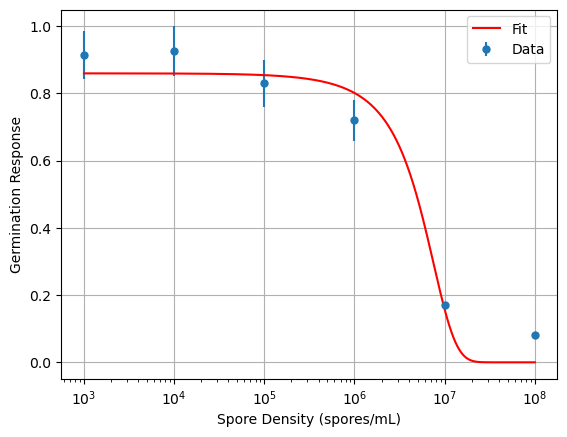

In [26]:
function germination_response(ρ, Pₛ, μ_γ, σ_γ, μ_ξ, σ_ξ, t)
    """
    Compute the germination_response for a given set of parameters.
    inputs:
        ρ - spore density in spores/mL
        μ_γ - mean inhibition threshold
        σ_γ - standard deviation of inhibition threshold
        μ_ξ - mean spore radius in um
        σ_ξ - standard deviation of spore radius in um
        Pₛ - permeation constant in um/s
        t - time
    output:
        germination_response - the germination response for the given parameters
    """

    # Convert units
    ρ = inverse_mL_to_cubic_um(ρ) # Convert from spores/mL to spores/m^3
    
    function integrand(ξ)
        V = 4/3 * π .* ξ^3
        A = 4 * π .* ξ^2
        τ = V ./ (Pₛ * A)
        ϕ = ρ .* V
        β = ϕ .+ (1 .- ϕ) .* exp.(-t ./ (τ .* (1 .- ϕ)))
        z = (β .- μ_γ) ./ σ_γ
        Φ = 0.5 .* (1 .+ erf.(z ./ √2))
        return (1 .- Φ) .* exp.(-(ξ .- μ_ξ).^2 ./ (2 * σ_ξ^2)) ./ (σ_ξ * √(2 * π))
    end

    return quadgk(x -> integrand(x), 0.0, Inf, rtol=1e-8)[1]
end

# Constants
μ_ξ = 1.275
σ_ξ = 0.075
t = 36000 # 10 hours in seconds

# Model wrapper
# wrapper(ρ, Pₛ, μ_γ, σ_γ) = germination_response(ρ, Pₛ, μ_γ, σ_γ, μ_ξ, σ_ξ, t)
wrapper(ρ_exp, params) = germination_response(10 .^ ρ_exp, 10 .^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, t)

println(wrapper(5, [3, 1e-6, 1e-8]))

# spore_densities = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
spore_density_exponents = collect(3:8)
germination_responses = [0.913, 0.925, 0.83, 0.72, 0.17, 0.08]
confidence_intervals_A = [0.071, 0.074, 0.07, 0.061, 0.003, 0.003]

# Initial guesses and bounds for the parameters
p0 = [3, 1e-6, 1e-8] # Initial guess for Pₛ, μ_γ, σ_γ
lower_bounds = [2, 1e-10, 1e-12]
upper_bounds = [5, 1.0, 0.1]

# Fit the model to the data
# fit = curve_fit(wrapper, spore_density_exponents, germination_responses, p0, lower=lower_bounds, upper=upper_bounds)
# println(fit.param)
# println(fit.resid)

# Define a scalar objective: sum of squared errors
function obj(params)
    ŷ = wrapper.(spore_density_exponents, Ref(params))
    return sum(abs2, ŷ .- germination_responses)
end

# res_nm = optimize(obj, p0, NelderMead(); 
#                   lower=lower_bounds, upper=upper_bounds,
#                   options=Optim.Options(iterations=10000))
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]
res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 3,
                 MaxSteps = 10000)
p_opt = best_candidate(res)

# wrapper(1e4, [1e-2, 2e-6, 0.0])

println("Optimized parameters:")
println("Pₛ: ", 10 .^ (- p_opt[1]))
println("μ_γ: ", p_opt[2])
println("σ_γ: ", p_opt[3])

# Plot data and fit
fig, ax = plt.subplots()
# ax.scatter(10 .^ spore_density_exponents, germination_responses, label="Data", color="blue")
ax.errorbar(10 .^ spore_density_exponents, germination_responses, yerr=confidence_intervals_A, fmt="o", markersize=5, label="Data")
sample_exp = LinRange(3, 8, 1000)
fit_responses = [wrapper(exponent, p_opt) for exponent in sample_exp]
ax.plot(10 .^ sample_exp, fit_responses, label="Fit", color="red")
ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

The fitted model bears close qualitative similarities to the experimental data, mostly in capturing the transition from full germination to no germination as $\rho_s$ increases from $10^5$ to $10^7$. The fitted concenration reduction is $6.168\times 10^{-5}\pm 3.66\times 10^{-5}$, encompassing a rather borad interval of concentration thresholds $c_T=\gamma c_0$ from $\mathcal{O}{(10^{-10})}\ \textrm{M}$ to a very slight decrease, still within the order of $10^{-5}\ \textrm{M}$. The fitted permeation constant is $P_s\approx 1.23\times10^{-4}\ \mu\textrm{m/s}$, close to the lower limit of observed permeabilities.

## References

- [1] Müller, H., Barthel, L., Schmideder, S., Schütze, T., Meyer, V., & Briesen, H. (2022). From spores to fungal pellets: A new high‐throughput image analysis highlights the structural development of Aspergillus niger. Biotechnology and Bioengineering, 119, 2182 - 2195.
- [2] Yu, J. (2010). Regulation of Development in Aspergillus nidulans and Aspergillus fumigatus. Mycobiology, 38, 229 - 237.
- [3] Herrero-García, E., Garzia, A., Cordobés, S., Espeso, E.A., & Ugalde, U. (2011). 8-Carbon oxylipins inhibit germination and growth, and stimulate aerial conidiation in Aspergillus nidulans. Fungal biology, 115 4-5, 393-400.